#### Load required libraries

In [1]:
import os
import numpy as np
from pyviscous import pyviscous as vs
from pyviscous import plot as vsplt

#### Load Sobol' function
The Sobol' function is defined as:
$$ Y = \prod_{i=1}^{n} \frac{|4X_i-2|+a_i}{1+a_i} $$
Set $ n=10 $, then $ X_1,…,X_{10} $ are the ten input variables uniformly distributed in $[0,1]$.<br>
We can conveniently get all the three types of function by changing $ a_i$ ([Kucherenko et al., 2011](https://www.sciencedirect.com/science/article/abs/pii/S0951832010002437)).

| Function type   | Function name   | $a_i$ value                                       |
| ----------------| ----------------| -----------------------------------------------   |
| Type A          | A1              | $ a_i = 25$\|sin(0.5$i$) + cos(0.75$i$+2)\|$ $    |
| Type A          | A2              | $ a_1 = a_2 = 0, a_3 = $...$ = a_d = 6.25 $       |
| Type B          | B               | $ a_i = 6.25 $ |
| Type C          | C               | $ a_i = 0 $ |

In [2]:
def Sobol_function(x, a):
    ''' Sobol function
    -------
    x: input array, shape (nSample,nVar).
    a: input array, shape (nSample,nVar).
    y: output array, shape (nSample,1).'''
    
    subPart = np.abs(4*x-2)
    y = np.prod((subPart+a)/(1+a), axis=1) 

    if len(np.shape(y)) == 1: # if shape(nSample,) -> (nSample,1)
        y = y.reshape(-1,1) 

    return y

#### Configurations

In [2]:
# Define a folder to save sensitivity results.
outputDir = os.path.join('.','functionA2')
if not os.path.exists(outputDir):
    os.makedirs(outputDir)

# Define other variables
nVar            = 10     # number of input x variables
paramLowerLimit = 0      # lower limit of x
paramUpperLimit = 1      # upper limit of x
nSample         = 10000  # number of input data samples

sampleFile      = os.path.join(outputDir,'samples_nVar%d.txt'%(nVar))  # sample file path 

#### 1. Generate input-output data

In [4]:
# If sampleFile exists, remove it to create a new one.
if os.path.exists(sampleFile): 
    os.remove(sampleFile)

# Generate input variable samples (x) 
x = np.zeros((nSample,nVar))
a = np.zeros((nSample,nVar))
a[:, 2:] = 6.52 # function A2
for iVar in range(nVar):
    prng = np.random.RandomState(iVar)
    x[:,iVar] = prng.uniform(low=paramLowerLimit, high=paramUpperLimit, size=nSample)               

# Generate the corresponding responses (y).
y = Sobol_function(x, a)

# Save input-output data.
samples    = np.concatenate((x,y), axis=1)    
header_str = ','.join(['X'+str(iVar+1) for iVar in range(nVar)])+',Y'
np.savetxt(sampleFile, samples, delimiter=',', header=header_str)
print('Input-output data saved: %s'%(sampleFile))

Input-output data saved: ./functionA2/samples_nVar10.txt


#### 2. Visualize input-output data and their transformations
For example, if we compute the first-order sensitivity index of $X_1$, then two variables $(X_1,Y)$ are included in VISCOUS. Through data preparation, we will get three sets of data:
- $(x_1,y)$ : Original input-output data. 
- $(x'_{1},y')$: Normalized data in range of [0, 1] using min-max scaling. 
- $(u_{x_1},u_y)$: Marginal Cumulative Distribution Function (CDF) data via rank transformation.

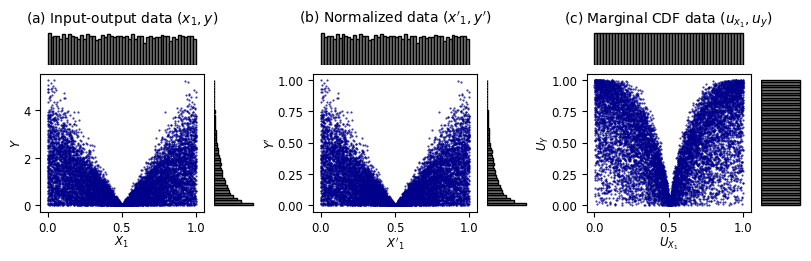

In [5]:
# --- Specify function arguments --- 
# Load input-output data
data = np.loadtxt(sampleFile, skiprows=0, delimiter=',')
x    = data[:,0:-1]
y    = data[:,-1].reshape(-1,1)    

# Index of the evaluated input variable, starting from zero.
xIndex = 0   # This means evaluating X1.    

# Output figure path
ofile = os.path.join(outputDir, f'x{xIndex + 1}_y.png')

# --- Plot ----
vsplt.plot_data_conversion(x,y,xIndex,ofile)

#### 3. Calculate the first-order sensitivity index
The first-order sensitivity index indicates the sensitivity of the function output (e.g., Y) to a function input variable (e.g., X1), while keeping all other variables fixed. It represents the direct influence of an input variable on the model output. <br>

-----
Input argument explanations for the **vs.viscous** function:  
- **x**: array, shape **(n_samples, n_xvariables)**. Input values in the input space. 
- **y**: array, shape **(n_samples, 1)**. Output values in the output space. 
- **xIndex**: **int**. The index of the evaluated input variable, starting from zero. 
- **sensType**: **str**. Type of sensitivity index calculation. Options: 'first', 'total'. <br>
*Optional:*
- **N1**: **int**, optional, default: 2000. Number of Monte Carlo samples used for the outer loop of the Gaussian Mixture Copula Model (GMCM)-based sampling.
- **N2**: **int**, optional, default: 2000. Number of Monte Carlo samples used for the inner loop of the GMCM-based sampling.
- **n_components**: **{int, 'optimal'}**, optional, default: **'optimal'**. The number of components used in GMCM inference. If **'optimal'**, it looks for an optimal number of components in the range of **[1, 9]**.
- **MSC**: **str**, optional, default: **'AIC'**. Model selection criteria. Options: 'AIC', 'BIC'.
- **verbose**: **bool**, optional, default: **False**. Display detailed processing information on your screen.

For more detailed information about the function, please refer to the source code of **pyviscous**.

In [3]:
# --- Specify function arguments --- 
# Load input-output data.
data = np.loadtxt(sampleFile, skiprows=0, delimiter=',')
x    = data[:,0:-1]
y    = data[:,-1].reshape(-1,1)    

# Index of the evaluated input variable, starting from zero.
xIndex = 0  # This means calculating X1's sensitivity index. 

# --- Calculate sensitivity index --- 
sens_indx_first, gmcm_first = vs.viscous(x, y, xIndex, 'first')  

Calculating first-order sensitivity index for variable index 0...
--- PART A: Data preparation
--- PART B: GMCM inference
--- PART C: Sensitivity index computation
    Best GMCM n_component =  6
    Sensitivity index = 0.371164


#### 4. Calculate the total-order sensitivity index
The total-order sensitivity index indicates the sensitivity of the function output (e.g., Y) to a function input variable (e.g., X1), accounting for both direct and interation effects with other variables. It reflects the overall importance of an input variable, considering its direct impact as well as its influence through interactions with other variables. <br>

Input argument explanations for the **vs.viscous** function are consistent with those provided above.

In [7]:
# --- Specify function arguments --- 
# Load input-output data
data = np.loadtxt(sampleFile, skiprows=0, delimiter=',')
x    = data[:,0:-1]
y    = data[:,-1].reshape(-1,1)    

# Index of the evaluated input variable, starting from zero.
xIndex = 0  # This means calculating X1's sensitivity index. 

# --- Calculate sensitivity index ---
sens_indx_total, gmcm_total = vs.viscous(x, y, xIndex, 'total')  

Calculating total-order sensitivity index for variable index 0...
--- PART A: Data preparation
--- PART B: GMCM inference
--- PART C: Sensitivity index computation
    Best GMCM n_component =  7
    Sensitivity index = 0.604521


#### 5. Check details of the fitted GMCM if interested
Taking the first-order sensitivity as an example, we can get the specific attributes of the fitted Gaussian Mixture Copula Model (GMCM), as illustrated below. Note GMCM and Gaussian Mixture Model (GMM) share parameters.

In [8]:
gmm                = gmcm_first               # Use gmcm_total if interested in the total-order one. 
gmmNComponents     = gmm.params.n_clusters    # number of Gaussain components
gmmWeights         = gmm.params.prob          # shape (n_components,)
gmmMeans           = gmm.params.means         # shape (n_components, n_variables). 
gmmCovariances     = gmm.params.covs          # (n_components, n_variables, n_variables) assuming covariance_type = ‘full’ by default.    

We can better understand **individual Gaussian components** by visualizing them using pyviscous built-in plot functions, as shown below.
Each GMCM component is a **multivariate Gaussian distribution** due to its nature of involving no less than two variables in the GMCM. The component's mean vector **${\mu}$** contains the means of the involved variables, and the covariance matrix ${\Sigma}$ describes the pairwise covariances between the involved variables. Mathematically: 
<p style="text-align: center;">${\mu} = [\mu_1, \mu_2, \ldots, \mu_n]$, where ${\mu_i}$ is the mean of variable $i$.</p> 
<p style="text-align: center;">
  ${\Sigma} = \begin{bmatrix}
  \sigma_{1}^2 & \sigma_{12} & \ldots & \sigma_{1n} \\
  \sigma_{21} & \sigma_{2}^2 & \ldots & \sigma_{2n} \\
  \vdots & \vdots & \ddots & \vdots \\
  \sigma_{n1} & \sigma_{n2} & \ldots & \sigma_{n}^2
  \end{bmatrix}$ </p>

Positive covariance means that two random variables tend to vary in the same direction. Negative covariance means that they vary in opposite directions. Zero covariance means that they don't vary together.

In the following plot, 
- The first row shows the mean values of each Gaussian component at distinct variables (e.g.,  $z_{x_1}$ and  $z_y$).
- The other rows show the covariance values of each Gaussian component at distinct variables (e.g.,  $z_{x_1}$ and  $z_y$). 

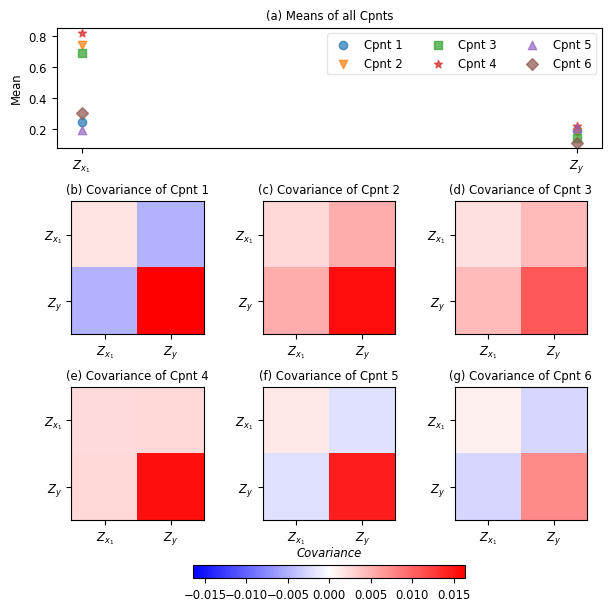

In [4]:
# Specify function arguments
gmm = gmcm_first   # Use gmcm_total if interested in the total-order one. 
sensType = 'first' # Use 'total' if interested in the total-order one. 
ofile = os.path.join(outputDir,'gmm_parameters_%s_order.png'%(sensType)) # Output figure path

# Plot
vsplt.plot_gmm_mean_cov(gmm, sensType, xIndex, ofile)  

To visualize how the GMM aligns with the input-output data, we do the following:
1. **Inverse CDF Computation**
- Recall that $(u_{x_1}, u_y)$ are the marginal CDFs for the provided input-output data (see Section 3 above). 
- Using the fitted GMM, we compute the inverse CDF values of $(u_{x_1}, u_y)$ within the model, getting $(z_{x_1}, z_y)$. 
- Subplot (a) shows the distribution of $(z_{x_1}, z_y)$ data within the GMM.
2. **Probability Density Calculation**
- Next, compute the correspoding joint probability density for each data point $(z_{x_1}, z_y)$ based on the PDF of GMM.
- Subplot(b) shows the joint probability density value associated with each $(z_{x_1}, z_y)$.
- These probability density values play a crucial role in GMCM inference, specifically serving as key inputs for calculating the log-likelihood in the utilized Expectation-Maximization (EM) algorithm.
3. **Gaussain Component Analysis**
- Lastly, to see the appearance of different Gaussian components in the joint PDF of the GMM, we identify the most dominant Gaussian component for each $(z_{x_1}, z_y)$ — the component to which a data point belongs with the highest probability.
- Subplot(c) implicitly reveals each Gaussian component within the GMM PDF, providing insight into their characteristics.

Note: This function supports the first-order related plot. The representation of more than two dimensions in the total-order term presents technical challenges.

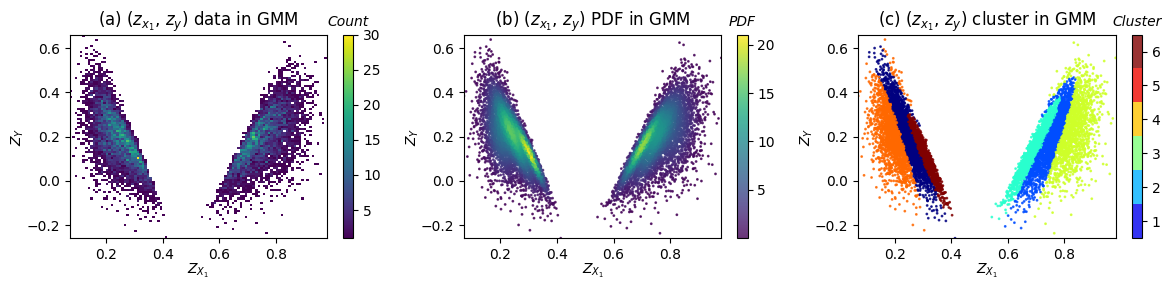

In [5]:
# Specify function arguments
gmm = gmcm_first   # Gaussian Mixture Model (GMM)
xIndex = 0         # Index of the evaluated input variable, starting from zero.
ofile = os.path.join(outputDir,'gmm_joint_fit.png') # Output figure path

# Plot
vsplt.plot_gmm_joint_fit(gmm, x, y, xIndex, ofile)